
Solving MILP optimization model with piecewise efficiency (CO₂ minimization)...
Optimization horizon: 1 day(s) with 60-minute resolution
Total time steps: 24
Optimal solution found! Total CO₂ objective: 8563.74 kg CO₂-eq


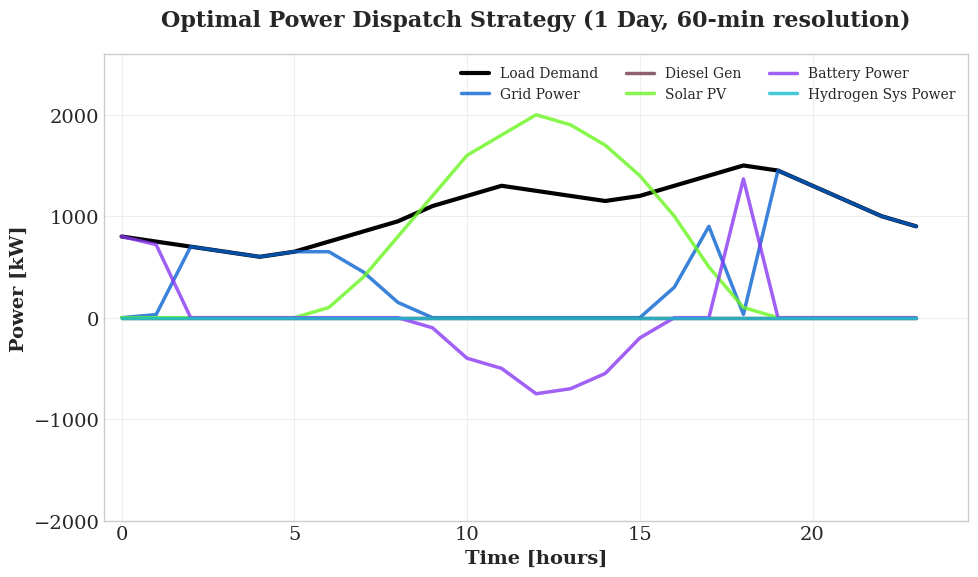

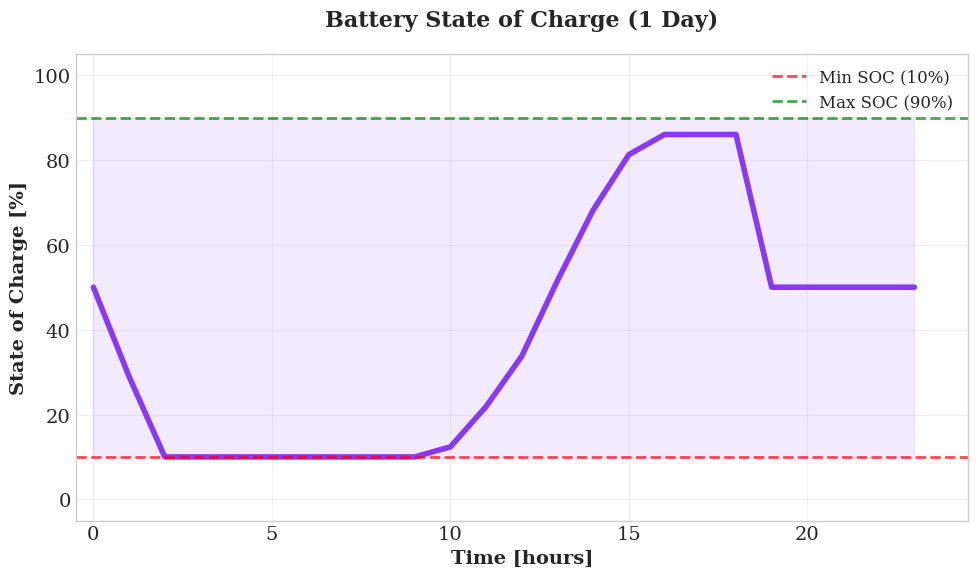

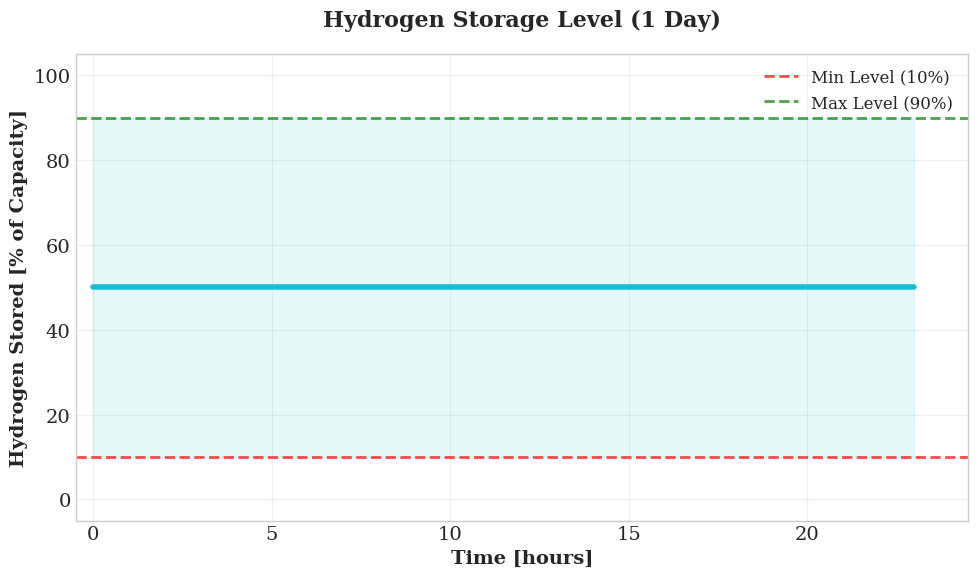


                    SUMMARY REPORT
Optimization Mode: CO₂ minimization
Optimization Period: 1 day(s)
Time Resolution: 60 minutes
Total Time Steps: 24

LOAD ANALYSIS:
  Total Load Demand:     25100.0 kWh
  Total Load Curtailed:      0.0 kWh
  Total Load Served:     25100.0 kWh (100.0%)

GRID ANALYSIS:
  Grid Import:           10912.0 kWh
  Grid Export:               0.0 kWh

DIESEL GENERATOR ANALYSIS:
  Energy Generated:          0.0 kWh
  Fuel Cost:                0.00 INR

BATTERY ANALYSIS:
  Energy Charged:         3200.0 kWh
  Energy Discharged:      2888.0 kWh

SOLAR ANALYSIS:
  Solar Available:       14500.0 kWh
  Solar Used:            14500.0 kWh (100.0%)
  Solar Curtailed:           0.0 kWh

HYDROGEN SYSTEM ANALYSIS:
  Energy to Electrolyzer:      0.0 kWh
  Energy from Fuel Cell:       0.0 kWh
  Hydrogen Produced:          0.00 kg
  Hydrogen Consumed:          0.00 kg
  Fuel Cell O&M Cost:         0.00 INR
  Round-Trip Efficiency:       0.0%
  Effective Conversion:   0.00 kWh/

In [14]:
# %%
import matplotlib.pyplot as plt
from pulp import *
import numpy as np
import pandas as pd


# %%
# =============================================================================
# USER CONFIGURABLE PARAMETERS
# =============================================================================

# Optimization mode selector                                         # NEW
# 1 = Minimize total operating COST (INR)
# 2 = Minimize CO₂ emissions (kg CO₂-eq) with high penalty for curtailment
optimization_mode = 2

# Optimization Time Parameters
num_days = 1                    # Number of days to optimize
time_resolution_minutes = 60    # Time step in minutes (e.g., 15, 30, 60)

# System connection parameters
grid_connection = 2000      # Grid connection capacity [kW]
solar_connection = 2000     # Solar connection capacity [kW]
battery_capacity = 40000    # Battery capacity [Ah]
battery_voltage = 100       # Battery voltage [V]
diesel_capacity = 2200      # Diesel generator capacity [kW]
fuel_price = 95             # INR per liter

# Hydrogen System Parameters
electrolyzer_capacity = 1000  # Max power consumption of the electrolyzer [kW]
fuel_cell_capacity = 800      # Max power generation of the fuel cell [kW]
h2_tank_capacity = 100        # Hydrogen storage tank capacity [kg]
fuel_cell_efficiency_percent = 0.60 # Fuel cell DC electrical efficiency (60%)

# Cost parameters
pv_energy_cost = 2.85               # PV energy cost [INR/kWh]
load_curtail_cost = 50              # Load curtailment penalty [INR/kWh]
battery_om_cost = 6.085             # Battery O&M cost [INR/kWh]
fuel_cell_om_cost = 1.5             # Fuel cell O&M cost [INR/kWh]
electrolyzer_om_cost = 0.5          # Electrolyzer O&M cost [INR/kWh]

# ============================
# CO2 EMISSION PARAMETERS     # NEW
# ============================
# All in kg CO2 per kWh of electrical energy
co2_grid_import = 0.716        # Grid import [kg CO2 / kWh]
co2_diesel = 0.9             # Diesel generator [kg CO2 / kWh]
co2_battery_discharge = 0.029  # Battery discharge [kg CO2 / kWh]
co2_pv_used = 0.046            # PV used [kg CO2 / kWh]
co2_fuel_cell = 0.001          # Assume green H2, no direct CO2
co2_electrolyzer = 0.0        # Assume no direct CO2 (electricity emissions counted at source)

# High CO2-equivalent penalty for load curtailment (only used in CO₂ mode)   # NEW
co2_load_curt_penalty = 5.0  # Very large penalty [kg CO2-eq / kWh curtailed]

# Weather condition selection
weather_condition = 1 # 1 = Sunny, 2 = Rainy

# Load and Price Profiles (24-hour base profiles)
load_profile_24h = [800, 750, 700, 650, 600, 650, 750, 850, 950, 1100, 1200, 1300, 1250, 1200, 1150, 1200, 1300, 1400, 1500, 1450, 1300, 1150, 1000, 900]
price_profile_24h = [3.5, 3.2, 3.0, 2.8, 2.5, 2.8, 4.2, 5.5, 6.2, 7.8, 8.5, 9.2, 8.8, 8.2, 7.5, 8.0, 8.8, 9.5, 10.2, 9.8, 8.5, 7.2, 5.5, 4.2]



# %%


# %%
# =============================================================================
# FIXED PARAMETERS AND MODEL SETUP
# =============================================================================

# Calculate time parameters
step_size = time_resolution_minutes / 60.0  # Convert to hours
steps_per_hour = int(60 / time_resolution_minutes)
time_horizon = num_days * 24 * steps_per_hour


def upsample_profile(hourly_profile, steps_per_hour, num_days):  
    """Upsample hourly profile using linear interpolation"""
    import numpy as np
    
    # Create hourly time points (0, 1, 2, ..., 23)
    hourly_times = np.arange(len(hourly_profile))
    
    # Create fine-resolution time points
    fine_times = np.linspace(0, len(hourly_profile) - 1, 
                             len(hourly_profile) * steps_per_hour)
    
    # Interpolate
    upsampled_single_day = np.interp(fine_times, hourly_times, hourly_profile).tolist()
    
    # Tile for multiple days
    return upsampled_single_day * num_days


# Central physical constant
H2_LHV = 33.3  # Lower Heating Value of Hydrogen [kWh/kg]

# Diesel generator parameters
diesel_min_power = 0.1 * diesel_capacity
diesel_max_power = diesel_capacity
fuel_slope, fuel_intercept = 0.18, 48

# Battery parameters
battery_storage_energy = (battery_capacity * battery_voltage) / 1000
battery_power = battery_storage_energy * 0.5

# Solar profiles (24-hour base profiles)
solar_profile_sunny = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0, 0.95, 0.85, 0.7, 0.5, 0.25, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0]
solar_profile_rainy = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

if weather_condition == 1:
    solar_profile_base = solar_profile_sunny
    weather_type = "Sunny Day"
else:
    solar_profile_base = solar_profile_rainy
    weather_type = "Rainy Day"

# Upsample all profiles for the optimization horizon
load_profile = upsample_profile(load_profile_24h, steps_per_hour, num_days)
price_profile = upsample_profile(price_profile_24h, steps_per_hour, num_days)
solar_profile = upsample_profile(solar_profile_base, steps_per_hour, num_days)

# System Capacities
grid_max_power = grid_connection
solar_capacity = solar_connection
bess_charge_capacity = bess_discharge_capacity = battery_power
bess_energy_capacity = battery_storage_energy
bess_min_soc, bess_max_soc = 0.1, 0.9
bess_charge_efficiency, bess_discharge_efficiency = 0.95, 0.95

# Hydrogen System Parameters
h2_min_soc, h2_max_soc = 0.1, 0.9
# Auto-calculate the kWh/kg value from the user-defined percentage
fuel_cell_efficiency_kwh_per_kg = H2_LHV * fuel_cell_efficiency_percent
fc_conversion_rate = 1 / fuel_cell_efficiency_kwh_per_kg

# =============================================================================
# PIECEWISE LINEAR ELECTROLYZER PARAMETERS
# =============================================================================

P_break1_percent = 0.20  # Peak efficiency occurs at 20% of max power
eff_at_break1 = 0.80     # Efficiency at the peak (at P_break1_percent)
eff_at_break2 = 0.75     # Efficiency at max power (100%)

P_break1 = electrolyzer_capacity * P_break1_percent
P_break2 = electrolyzer_capacity

H2_at_break1 = (P_break1 * 1 * eff_at_break1) / H2_LHV
H2_at_break2 = (P_break2 * 1 * eff_at_break2) / H2_LHV

slope_s1 = H2_at_break1 / P_break1 if P_break1 > 0 else 0
slope_s2 = (H2_at_break2 - H2_at_break1) / (P_break2 - P_break1) if (P_break2 - P_break1) > 0 else 0

width_s1 = P_break1
width_s2 = P_break2 - P_break1

# =============================================================================
# OPTIMIZATION SETUP
# =============================================================================

bess_min_level, bess_max_level = bess_min_soc * bess_energy_capacity, bess_max_soc * bess_energy_capacity
h2_min_level, h2_max_level = h2_min_soc * h2_tank_capacity, h2_max_soc * h2_tank_capacity

model = LpProblem('Energy_System_Optimization', LpMinimize)
T = range(time_horizon)

# Decision Variables
P_grid = {t: LpVariable(f"P_grid_{t}", -grid_max_power, grid_max_power) for t in T}
P_load_curt = {t: LpVariable(f"P_load_curt_{t}", 0) for t in T}
P_diesel = {t: LpVariable(f"P_diesel_{t}", 0, diesel_max_power) for t in T}
z_diesel = {t: LpVariable(f"z_diesel_{t}", cat='Binary') for t in T}
F_diesel = {t: LpVariable(f"F_diesel_{t}", 0) for t in T}
P_charge = {t: LpVariable(f"P_charge_{t}", 0, bess_charge_capacity) for t in T}
P_discharge = {t: LpVariable(f"P_discharge_{t}", 0, bess_discharge_capacity) for t in T}
E_battery = {t: LpVariable(f"E_battery_{t}", bess_min_level, bess_max_level) for t in T}
z_bess = {t: LpVariable(f"z_bess_{t}", cat='Binary') for t in T}
P_pv_used = {t: LpVariable(f"P_pv_used_{t}", 0) for t in T}
P_solar_curt = {t: LpVariable(f"P_solar_curt_{t}", 0) for t in T}

# Hydrogen system variables
P_elec = {t: LpVariable(f"P_elec_{t}", 0, electrolyzer_capacity) for t in T}
P_fc = {t: LpVariable(f"P_fc_{t}", 0, fuel_cell_capacity) for t in T}
E_h2 = {t: LpVariable(f"E_h2_{t}", h2_min_level, h2_max_level) for t in T}
z_h2 = {t: LpVariable(f"z_h2_{t}", cat='Binary') for t in T}

# Piecewise model variables for electrolyzer
P_elec_s1 = {t: LpVariable(f"P_elec_s1_{t}", 0, width_s1) for t in T}
P_elec_s2 = {t: LpVariable(f"P_elec_s2_{t}", 0, width_s2) for t in T}
z_elec_s2 = {t: LpVariable(f"z_elec_s2_{t}", cat='Binary') for t in T}
H_produced = {t: LpVariable(f"H_produced_{t}", 0) for t in T}

# Additional variable to capture grid import only (P_grid > 0) for emissions  # NEW
P_grid_import = {t: LpVariable(f"P_grid_import_{t}", 0) for t in T}  # [kW], >= 0

# =============================================================================
# CONSTRAINTS
# =============================================================================

# 1. Energy balance constraint
for t in T:
    load_served = load_profile[t] - P_load_curt[t]
    supply = P_pv_used[t] + P_diesel[t] + P_discharge[t] + P_grid[t] + P_fc[t]
    demand = load_served + P_charge[t] + P_elec[t]
    model += (supply == demand), f"power_balance_{t}"

# 1a. Limit load curtailment to at most the demand at each step             # NEW
for t in T:
    model += P_load_curt[t] <= load_profile[t], f"load_curt_max_{t}"

# 2. Solar constraints
for t in T:
    solar_available = solar_profile[t] * solar_capacity
    model += P_pv_used[t] + P_solar_curt[t] == solar_available, f"pv_balance_{t}"

# 3. Diesel generator constraints
for t in T:
    model += P_diesel[t] >= diesel_min_power * z_diesel[t], f"diesel_min_{t}"
    model += P_diesel[t] <= diesel_max_power * z_diesel[t], f"diesel_max_{t}"
    model += F_diesel[t] >= fuel_slope * P_diesel[t] + fuel_intercept * z_diesel[t], f"fuel_cons_{t}"

# 4. Battery constraints
initial_battery_level = 0.5 * bess_energy_capacity
model += E_battery[0] == initial_battery_level
for t in T:
    if t < time_horizon - 1:
        model += (E_battery[t+1] == E_battery[t] +
                  step_size * (P_charge[t] * bess_charge_efficiency -
                               P_discharge[t] * (1 / bess_discharge_efficiency))), f"battery_dynamics_{t}"
    model += P_charge[t] <= bess_charge_capacity * (1 - z_bess[t]), f"charge_limit_{t}"
    model += P_discharge[t] <= bess_discharge_capacity * z_bess[t], f"discharge_max_{t}"
model += (initial_battery_level == E_battery[time_horizon-1] +
          step_size * (P_charge[time_horizon-1] * bess_charge_efficiency -
                       P_discharge[time_horizon-1] * (1 / bess_discharge_efficiency))), "final_battery_level_cyclic"

# 5. Hydrogen System Constraints
initial_h2_level = 0.5 * h2_tank_capacity
model += E_h2[0] == initial_h2_level

for t in T:
    model += P_elec[t] == P_elec_s1[t] + P_elec_s2[t], f"elec_power_sum_{t}"
    model += H_produced[t] == (P_elec_s1[t] * slope_s1) + (P_elec_s2[t] * slope_s2), f"h2_production_calc_{t}"
    model += P_elec_s1[t] >= width_s1 * z_elec_s2[t], f"elec_s1_fill_before_s2_{t}"
    model += P_elec_s2[t] <= width_s2 * z_elec_s2[t], f"elec_s2_activation_{t}"
    model += P_fc[t] <= fuel_cell_capacity * z_h2[t], f"fc_limit_{t}"
    model += P_elec[t] <= electrolyzer_capacity * (1 - z_h2[t]), f"elec_limit_{t}"
    
    if t < time_horizon - 1:
        model += (E_h2[t+1] == E_h2[t] + H_produced[t] * step_size -
                  (P_fc[t] * step_size * fc_conversion_rate)), f"h2_dynamics_{t}"

model += (E_h2[0] == E_h2[time_horizon-1] +
          H_produced[time_horizon-1] * step_size -
          (P_fc[time_horizon-1] * step_size * fc_conversion_rate)), "final_h2_level_cyclic"

# 6. Grid import definition for emissions (capture positive part of P_grid)  # NEW
for t in T:
    model += P_grid_import[t] >= P_grid[t], f"grid_import_ge_pgrid_{t}"
    model += P_grid_import[t] >= 0, f"grid_import_ge_0_{t}"


# =============================================================================
# OBJECTIVE FUNCTION (COST or CO₂)
# =============================================================================

# COST objective components (as in original code, with step_size on diesel)  # MODIFIED
cost_components = []
for t in T:
    cost_components.extend([
        step_size * price_profile[t] * P_grid[t],
        step_size * load_curtail_cost * P_load_curt[t],
        step_size * fuel_price * F_diesel[t],         # MODIFIED: scaled by step_size
        step_size * pv_energy_cost * P_pv_used[t],
        step_size * battery_om_cost * P_discharge[t],
        step_size * fuel_cell_om_cost * P_fc[t],
        step_size * electrolyzer_om_cost * P_elec[t]
    ])
cost_expr = lpSum(cost_components)  # NEW

# CO₂ objective components (physical + curtailment penalty)                 # NEW
co2_physical_components = []
co2_curt_components = []
for t in T:
    co2_physical_components.extend([
        step_size * co2_grid_import        * P_grid_import[t],
        step_size * co2_diesel             * P_diesel[t],
        step_size * co2_battery_discharge  * P_discharge[t],
        step_size * co2_pv_used            * P_pv_used[t],
        step_size * co2_fuel_cell          * P_fc[t],
        step_size * co2_electrolyzer       * P_elec[t],
    ])
    co2_curt_components.append(
        step_size * co2_load_curt_penalty * P_load_curt[t]
    )

co2_physical_expr = lpSum(co2_physical_components)  # NEW
co2_curt_expr = lpSum(co2_curt_components)          # NEW

# Select objective based on optimization_mode                                # NEW
if optimization_mode == 1:
    model += cost_expr
elif optimization_mode == 2:
    model += co2_physical_expr + co2_curt_expr
else:
    raise ValueError("optimization_mode must be 1 (Cost) or 2 (CO2).")


# =============================================================================
# SOLVE AND ANALYZE
# =============================================================================
mode_str = "COST minimization" if optimization_mode == 1 else "CO₂ minimization"
print(f"\nSolving MILP optimization model with piecewise efficiency ({mode_str})...")
print(f"Optimization horizon: {num_days} day(s) with {time_resolution_minutes}-minute resolution")
print(f"Total time steps: {time_horizon}")
solver = PULP_CBC_CMD(msg=0, timeLimit=180, gapRel=0.01)
model.solve()

if optimization_mode == 1:
    print(f"Optimal solution found! Total cost: {value(model.objective):.2f} INR")
else:
    print(f"Optimal solution found! Total CO₂ objective: {value(model.objective):.2f} kg CO₂-eq")

# Post-processing and results extraction
h2_levels_for_plot = []
for t in T:
    h2_at_end_of_t = value(E_h2[t]) + value(H_produced[t]) * step_size - value(P_fc[t]) * step_size * fc_conversion_rate
    h2_levels_for_plot.append(h2_at_end_of_t)

# Create time axis in hours for plotting
time_axis = [t * step_size for t in range(time_horizon)]

results_data = {
    'Time_Step': list(range(time_horizon)),
    'Time_Hours': time_axis,
    'Load_Demand': load_profile,
    'Price': price_profile,
    'Grid_Power': [value(P_grid[t]) for t in T],
    'Grid_Import': [value(P_grid_import[t]) for t in T],   # NEW
    'Load_Curtailed': [value(P_load_curt[t]) for t in T],
    'Diesel_Power': [value(P_diesel[t]) for t in T],
    'Fuel_Cost': [step_size * fuel_price * value(F_diesel[t]) for t in T],  # MODIFIED
    'Charge_Power': [value(P_charge[t]) for t in T],
    'Discharge_Power': [value(P_discharge[t]) for t in T],
    'Net_Battery_Power': [value(P_discharge[t]) - value(P_charge[t]) for t in T],
    'Battery_Level': [value(E_battery[t]) for t in T],
    'Battery_SOC': [value(E_battery[t]) / bess_energy_capacity * 100 for t in T],
    'Solar_Available': [solar_profile[t] * solar_capacity for t in T],
    'PV_Used': [value(P_pv_used[t]) for t in T],
    'Solar_Curtailed': [value(P_solar_curt[t]) for t in T],
    'Electrolyzer_Power': [value(P_elec[t]) for t in T],
    'Fuel_Cell_Power': [value(P_fc[t]) for t in T],
    'Net_H2_Power': [value(P_fc[t]) - value(P_elec[t]) for t in T],
    'H2_Level': h2_levels_for_plot,
    'H2_SOC': [level / h2_tank_capacity * 100 for level in h2_levels_for_plot],
    'Fuel_Cell_OM_Cost': [fuel_cell_om_cost * value(P_fc[t]) for t in T],
    'H2_Produced_kg': [value(H_produced[t]) for t in T]
}
results_df = pd.DataFrame(results_data)


# %%
# =============================================================================
# VISUALIZATION
# =============================================================================

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'font.family': 'serif', 'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
colors = {'load': "#010103", 'grid': "#0863D1", 'diesel': "#72394F", 'battery': "#8938F3", 'solar': "#6BF520", 'h2': "#17becf", 'price': "#CA3510", 'cost': "#25E8F3"}

# Plot 1: Power Dispatch Strategy
plt.figure(figsize=(10, 6))
plt.plot(results_df['Time_Hours'], results_df['Load_Demand'], color=colors['load'], label='Load Demand', linewidth=3, markersize=6, markerfacecolor='white', markeredgewidth=2, markevery=max(1, len(results_df)//100))
plt.plot(results_df['Time_Hours'], results_df['Grid_Power'],  color=colors['grid'], label='Grid Power', linewidth=2.5, markersize=5, alpha=0.8, markevery=max(1, len(results_df)//100))
plt.plot(results_df['Time_Hours'], results_df['Diesel_Power'],  color=colors['diesel'], label='Diesel Gen', linewidth=2.5, markersize=5, alpha=0.8, markevery=max(1, len(results_df)//100))
plt.plot(results_df['Time_Hours'], results_df['PV_Used'], color=colors['solar'], label='Solar PV', linewidth=2.5, markersize=5, alpha=0.8, markevery=max(1, len(results_df)//100))
plt.plot(results_df['Time_Hours'], results_df['Net_Battery_Power'],  color=colors['battery'], label='Battery Power', linewidth=2.5, markersize=5, alpha=0.8, markevery=max(1, len(results_df)//100))
plt.plot(results_df['Time_Hours'], results_df['Net_H2_Power'],  color=colors['h2'], label='Hydrogen Sys Power', linewidth=2.5, markersize=6, alpha=0.8, markevery=max(1, len(results_df)//100))

plt.title(f'Optimal Power Dispatch Strategy ({num_days} Day{"s" if num_days > 1 else ""}, {time_resolution_minutes}-min resolution)', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Time [hours]', fontsize=14)
plt.ylabel('Power [kW]', fontsize=14)
plt.legend(loc='upper right', fontsize=10, framealpha=0.9, ncol=3)
plt.grid(True, alpha=0.3)
plt.xlim(-0.5, num_days * 24 + 0.5)
plt.ylim(min(-2000, min(results_df['Grid_Power']) - 0.1*grid_max_power), max(1.3*grid_max_power, max(results_df['Load_Demand']) + 0.1*grid_max_power))
plt.tight_layout()
plt.show()

# Plot 2: Battery State of Charge
plt.figure(figsize=(10, 6))
plt.plot(results_df['Time_Hours'], results_df['Battery_SOC'],  color=colors['battery'], linewidth=4, markersize=6, markerfacecolor='white', markeredgewidth=3, markevery=max(1, len(results_df)//100))
plt.axhline(y=bess_min_soc*100, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'Min SOC ({bess_min_soc*100:.0f}%)')
plt.axhline(y=bess_max_soc*100, color='green', linestyle='--', alpha=0.7, linewidth=2, label=f'Max SOC ({bess_max_soc*100:.0f}%)')
plt.fill_between(results_df['Time_Hours'], bess_min_soc*100, bess_max_soc*100, alpha=0.1, color=colors['battery'])
plt.title(f'Battery State of Charge ({num_days} Day{"s" if num_days > 1 else ""})', fontsize=16, pad=20)
plt.xlabel('Time [hours]', fontsize=14)
plt.ylabel('State of Charge [%]', fontsize=14)
plt.ylim(-5, 105)
plt.xlim(-0.5, num_days * 24 + 0.5)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, framealpha=0.9, loc = 'upper right')
plt.tight_layout()
plt.show()

# Plot 3: Hydrogen Storage Level
plt.figure(figsize=(10, 6))
plt.plot(results_df['Time_Hours'], results_df['H2_SOC'], color=colors['h2'], linewidth=4, markersize=7, markerfacecolor='white', markeredgewidth=3, markevery=max(1, len(results_df)//100))
plt.axhline(y=h2_min_soc*100, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'Min Level ({h2_min_soc*100:.0f}%)')
plt.axhline(y=h2_max_soc*100, color='green', linestyle='--', alpha=0.7, linewidth=2, label=f'Max Level ({h2_max_soc*100:.0f}%)')
plt.fill_between(results_df['Time_Hours'], h2_min_soc*100, h2_max_soc*100, alpha=0.1, color=colors['h2'])
plt.title(f'Hydrogen Storage Level ({num_days} Day{"s" if num_days > 1 else ""})', fontsize=16, pad=20)
plt.xlabel('Time [hours]', fontsize=14)
plt.ylabel('Hydrogen Stored [% of Capacity]', fontsize=14)
plt.ylim(-5, 105)
plt.xlim(-0.5, num_days * 24 + 0.5)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, framealpha=0.9, loc = 'upper right')
plt.tight_layout()
plt.show()


# %%


# %%
# =============================================================================
# SUMMARY REPORT
# =============================================================================

print("\n" + "="*60)
print("                    SUMMARY REPORT")
print("="*60)
print(f"Optimization Mode: {'Cost minimization' if optimization_mode == 1 else 'CO₂ minimization'}")
print(f"Optimization Period: {num_days} day(s)")
print(f"Time Resolution: {time_resolution_minutes} minutes")
print(f"Total Time Steps: {time_horizon}")

# Extract totals from DataFrame (accounting for step_size)
total_load_demand = sum(results_df['Load_Demand']) * step_size
total_load_curt = sum(results_df['Load_Curtailed']) * step_size
total_load_served = total_load_demand - total_load_curt
grid_import_energy = sum(max(0, p) for p in results_df['Grid_Power']) * step_size
grid_export_energy = sum(max(0, -p) for p in results_df['Grid_Power']) * step_size
total_diesel_energy = sum(results_df['Diesel_Power']) * step_size
total_fuel_cost = sum(results_df['Fuel_Cost'])
total_charge = sum(results_df['Charge_Power']) * step_size
total_discharge = sum(results_df['Discharge_Power']) * step_size
total_solar = sum(results_df['PV_Used']) * step_size
total_available = sum(results_df['Solar_Available']) * step_size

# Hydrogen analysis
total_h2_produced_kwh_input = sum(results_df['Electrolyzer_Power']) * step_size
total_h2_produced_kg = sum(results_df['H2_Produced_kg']) * step_size
total_h2_consumed_kwh_output = sum(results_df['Fuel_Cell_Power']) * step_size
total_h2_consumed_kg = total_h2_consumed_kwh_output * fc_conversion_rate
total_fc_om_cost = sum(results_df['Fuel_Cell_OM_Cost']) * step_size
round_trip_efficiency_h2 = (total_h2_consumed_kwh_output / total_h2_produced_kwh_input * 100) if total_h2_produced_kwh_input > 0 else 0

print(f"\nLOAD ANALYSIS:")
print(f"  Total Load Demand:    {total_load_demand:8.1f} kWh")
print(f"  Total Load Curtailed: {total_load_curt:8.1f} kWh")
print(f"  Total Load Served:    {total_load_served:8.1f} kWh ({total_load_served/total_load_demand*100:.1f}%)")

print(f"\nGRID ANALYSIS:")
print(f"  Grid Import:          {grid_import_energy:8.1f} kWh")
print(f"  Grid Export:          {grid_export_energy:8.1f} kWh")

print(f"\nDIESEL GENERATOR ANALYSIS:")
print(f"  Energy Generated:     {total_diesel_energy:8.1f} kWh")
print(f"  Fuel Cost:            {total_fuel_cost:8.2f} INR")

print(f"\nBATTERY ANALYSIS:")
print(f"  Energy Charged:       {total_charge:8.1f} kWh")
print(f"  Energy Discharged:    {total_discharge:8.1f} kWh")

print(f"\nSOLAR ANALYSIS:")
print(f"  Solar Available:      {total_available:8.1f} kWh")
print(f"  Solar Used:           {total_solar:8.1f} kWh" + (f" ({total_solar/total_available*100:.1f}%)" if total_available > 0 else ""))
print(f"  Solar Curtailed:      {sum(results_df['Solar_Curtailed']) * step_size:8.1f} kWh")

print(f"\nHYDROGEN SYSTEM ANALYSIS:")
print(f"  Energy to Electrolyzer: {total_h2_produced_kwh_input:8.1f} kWh")
print(f"  Energy from Fuel Cell:  {total_h2_consumed_kwh_output:8.1f} kWh")
print(f"  Hydrogen Produced:      {total_h2_produced_kg:8.2f} kg")
print(f"  Hydrogen Consumed:      {total_h2_consumed_kg:8.2f} kg")
print(f"  Fuel Cell O&M Cost:     {total_fc_om_cost:8.2f} INR")
print(f"  Round-Trip Efficiency:  {round_trip_efficiency_h2:8.1f}%")
print(f"  Effective Conversion:   {total_h2_produced_kwh_input/total_h2_produced_kg if total_h2_produced_kg > 0 else 0:.2f} kWh/kg")

# ===============================
# CO2 EMISSIONS ANALYSIS
# ===============================
total_co2_grid = sum(co2_grid_import       * value(P_grid_import[t]) * step_size for t in T)
total_co2_diesel = sum(co2_diesel          * value(P_diesel[t])      * step_size for t in T)
total_co2_batt = sum(co2_battery_discharge * value(P_discharge[t])   * step_size for t in T)
total_co2_pv = sum(co2_pv_used             * value(P_pv_used[t])     * step_size for t in T)
total_co2_fc = sum(co2_fuel_cell           * value(P_fc[t])          * step_size for t in T)
total_co2_elec = sum(co2_electrolyzer      * value(P_elec[t])        * step_size for t in T)
total_co2_physical = total_co2_grid + total_co2_diesel + total_co2_batt + total_co2_pv + total_co2_fc + total_co2_elec

if optimization_mode == 2:
    total_co2_curt = sum(co2_load_curt_penalty * value(P_load_curt[t]) * step_size for t in T)
else:
    total_co2_curt = 0.0

total_co2_objective = total_co2_physical + total_co2_curt

print(f"\nCO₂ EMISSIONS ANALYSIS:")
print(f"  Grid Emissions:        {total_co2_grid:8.2f} kg CO₂")
print(f"  Diesel Emissions:      {total_co2_diesel:8.2f} kg CO₂")
print(f"  Battery Emissions:     {total_co2_batt:8.2f} kg CO₂")
print(f"  PV Emissions:          {total_co2_pv:8.2f} kg CO₂")
print(f"  Fuel Cell Emissions:   {total_co2_fc:8.2f} kg CO₂")
print(f"  Electrolyzer Emissions:{total_co2_elec:8.2f} kg CO₂")
if optimization_mode == 2:
    print(f"  Curtailment Penalty:   {total_co2_curt:8.2f} kg CO₂-eq")
print(f"  ──────────────────────────────────")
print(f"  TOTAL CO₂ (physical):  {total_co2_physical:8.2f} kg CO₂")
if optimization_mode == 2:
    print(f"  TOTAL CO₂ OBJECTIVE:   {total_co2_objective:8.2f} kg CO₂-eq")
print(f"  Emissions per kWh served: {total_co2_physical/total_load_served if total_load_served > 0 else 0:8.4f} kg CO₂/kWh")

# ===============================
# COST BREAKDOWN
# ===============================
print(f"\nCOST BREAKDOWN ({'objective' if optimization_mode == 1 else 'reference only'}):")
grid_cost = sum(results_df['Grid_Power'].iloc[t] * results_df['Price'].iloc[t] * step_size for t in range(time_horizon))
solar_cost_total = total_solar * pv_energy_cost
battery_om_cost_total = total_discharge * battery_om_cost
electrolyzer_om_cost_total = total_h2_produced_kwh_input * electrolyzer_om_cost
total_cost = grid_cost + total_fuel_cost + solar_cost_total + battery_om_cost_total + total_fc_om_cost + electrolyzer_om_cost_total

print(f"  Grid Cost:              {grid_cost:8.2f} INR")
print(f"  Diesel Fuel Cost:       {total_fuel_cost:8.2f} INR")
print(f"  Solar Cost:             {solar_cost_total:8.2f} INR")
print(f"  Battery O&M Cost:       {battery_om_cost_total:8.2f} INR")
print(f"  Fuel Cell O&M Cost:     {total_fc_om_cost:8.2f} INR")
print(f"  Electrolyzer O&M Cost:  {electrolyzer_om_cost_total:8.2f} INR")
print(f"  ──────────────────────────────────")
print(f"  TOTAL COST:             {total_cost:8.2f} INR")
print(f"  Cost per kWh served:    {total_cost/total_load_served if total_load_served > 0 else 0:8.2f} INR/kWh")

print("\nSYSTEM CONFIGURATION:")
print("  ✓ Grid Connection")
print("  ✓ Diesel Generator")
print("  ✓ Battery System")
print("  ✓ Solar PV")
print("  ✓ Hydrogen System (Electrolyzer + Fuel Cell)")
print(f"  Weather: {weather_type}")
print("="*60)

# %%
